## 导入所需库

In [289]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import cm  # 导入颜色映射
from matplotlib import pyplot as plt
from manim import *
import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['SimHei'] #指定默认字体为黑体
mpl.rcParams['axes.unicode_minus'] = False #正常显示负号
rainbow_color = [RED, ORANGE, YELLOW, GREEN ,BLUE, PURPLE]
rainbow_color5 = [RED, ORANGE, GREEN ,BLUE, PURPLE]
rainbow_color8 = [RED, ORANGE, YELLOW ,GREEN_B,GREEN ,BLUE, PURPLE,WHITE]

like_hood_list = [
    [1,1,1,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0],
    [0,0,0,0,1],
    [0,0,1,1,0],
]

type_dict_like = {
    "b" : {
        "fill_color" : LIGHT_GRAY,
        "fill_opacity" : 0.5,
        "stroke_opacity" : 0.8,
    },
    "m_y" : {
        "fill_color" : BLACK,
        "stroke_color" : BLUE,
        "fill_opacity" : 1,
        "stroke_opacity" : 1,
    },
    "m_n" : {
        "fill_color" : WHITE,
        "stroke_color" : BLUE,
        "fill_opacity" : 1,
        "stroke_opacity" : 1,
    },
}

## 定义 RBM 类

In [6]:
%%manim -qh -v WARNING Code_5

code_input = [
    """
        def __init__(
            self, 
            visible_units, 
            hidden_units, 
            learning_rate=0.1
        ):
        
            self.visible_units = visible_units
            self.hidden_units = hidden_units
            self.learning_rate = learning_rate

            self.weights = np.random.normal(
                scale=0.01, 
                size=(self.visible_units, self.hidden_units),
            )
            self.visible_bias = np.zeros(self.visible_units)
            self.hidden_bias = np.zeros(self.hidden_units)
    """,
    """
        def sigmoid(self, x):
            return 1.0 / (1 + np.exp(-x))
    """,
    """
        def sample_hidden(self, visible):
            activation = np.dot(visible, self.weights) + self.hidden_bias
            prob_hidden = self.sigmoid(activation)
            return prob_hidden, np.random.binomial(1, prob_hidden)
    """,
    """
        def sample_visible(self, hidden):
            activation = np.dot(hidden, self.weights.T) + self.visible_bias
            prob_visible = self.sigmoid(activation)
            return prob_visible, np.random.binomial(1, prob_visible)
    """,
    """
        def contrastive_divergence(self, data):
            pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
            pos_associations = np.dot(data.T, pos_hidden_probs)

            neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
            neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            self.weights += 
                self.learning_rate * (pos_associations - neg_associations)
            self.visible_bias += 
                self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
            self.hidden_bias += 
                self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)
    """
]

class Code_5(Scene):
    def construct(self):
        code = Code(
        code=code_input[4],
            font_size= 18,
            line_spacing=0.4,
            insert_line_no=False,
            background="rectangle",
            style = Code.styles_list[9],
            language='python',
        )
        self.play(Create(code),run_time = 10)
        self.wait()

In [11]:
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data, epochs=1000):
        loss_list = []
        for epoch in range(epochs):
            self.contrastive_divergence(data)
            if epoch % 100 == 0:
                loss = np.mean((data - self.sample_visible(self.sample_hidden(data)[1])[0])**2)
                loss_list.append(loss)
                print(f'迭代 {epoch}: 损失: {loss}')

        return loss_list

    def reconstruct(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible


In [31]:
# 创建简单的二进制数据
data = np.array([[1, 1, 0, 0],
                 [1, 0, 1, 0],
                 [0, 1, 1, 0],
                 [0, 0, 1, 1]])

# 创建 RBM 实例
rbm = RBM(visible_units=4, hidden_units=2, learning_rate=0.1)

# 训练 RBM
rbm.train(data, epochs=1000)
# 检查重构后的可见层
_, hidden_states = rbm.sample_hidden(data)
reconstructed_visible, _ = rbm.sample_visible(hidden_states)
print("Original data:")
print(data)
print("Reconstructed data:")
print(reconstructed_visible)


迭代 0: 损失: 0.2417471737554254
迭代 100: 损失: 0.2144235950056796
迭代 200: 损失: 0.08651348479634144
迭代 300: 损失: 0.0720062197054977
迭代 400: 损失: 0.1363901919553539
迭代 500: 损失: 0.06449657426408556
迭代 600: 损失: 0.06370721530100362
迭代 700: 损失: 0.06352811380741483
迭代 800: 损失: 0.06319472914679364
迭代 900: 损失: 0.06310930508127152
Original data:
[[1 1 0 0]
 [1 0 1 0]
 [0 1 1 0]
 [0 0 1 1]]
Reconstructed data:
[[9.81237089e-01 9.82634275e-01 5.89000884e-02 8.43118034e-04]
 [5.04374297e-01 5.04809990e-01 9.96667371e-01 8.60468108e-03]
 [5.04374297e-01 5.04809990e-01 9.96667371e-01 8.60468108e-03]
 [1.54991042e-02 1.36419482e-02 9.99141902e-01 9.31227857e-01]]


迭代 0: 损失: 0.24850784140110777
迭代 100: 损失: 0.2110102690327471
迭代 200: 损失: 0.08167370552208172
迭代 300: 损失: 0.0699950807861193
迭代 400: 损失: 0.06588102260782507
迭代 500: 损失: 0.06480687384978845
迭代 600: 损失: 0.06392792487450176
迭代 700: 损失: 0.06325834637360497
迭代 800: 损失: 0.06301232987410123
迭代 900: 损失: 0.06299413280397098


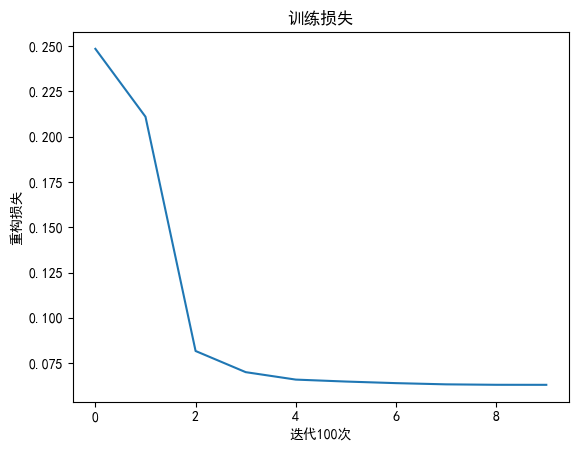

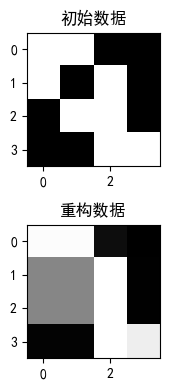

In [32]:
# 创建简单的二进制数据
data = np.array([[1, 1, 0, 0],
                 [1, 0, 1, 0],
                 [0, 1, 1, 0],
                 [0, 0, 1, 1],])

# 创建 RBM 实例
rbm = RBM(visible_units=4, hidden_units=2, learning_rate=0.1)

# 训练 RBM 并记录损失
loss_list = rbm.train(data, epochs=1000)

# 绘制训练过程中损失的变化
plt.plot(loss_list)
plt.xlabel('迭代100次')
plt.ylabel('重构损失')
plt.title('训练损失')
plt.show()

# 获取重构数据
reconstructed_data = rbm.reconstruct(data)

# 绘制原始数据与重构数据的对比
def plot_data_comparison(original, reconstructed):
    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    
    # 原始数据
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('初始数据')

    # 重构数据
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title('重构数据')

    plt.tight_layout()
    plt.show()

# 可视化原始数据与重构数据
plot_data_comparison(data, reconstructed_data)


In [19]:
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence_step(self, data):
        # 正相位：由输入数据计算隐藏层
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        # 负相位：由隐藏层重构可见层
        neg_visible_probs, neg_visible_states = self.sample_visible(pos_hidden_states)
        # 使用负相位隐藏层重新计算隐藏层
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        
        return pos_hidden_probs, pos_hidden_states, neg_visible_probs, neg_hidden_probs

    def visualize_step(self, data, epoch):
        pos_hidden_probs, pos_hidden_states, neg_visible_probs, neg_hidden_probs = self.contrastive_divergence_step(data)

        fig, axes = plt.subplots(3, 2, figsize=(10, 10))

        # 原始可见层
        axes[0, 0].imshow(data, cmap='gray')
        axes[0, 0].set_title('Original Visible Layer')

        # 隐藏层激活值 (正相位)
        axes[1, 0].imshow(pos_hidden_probs, cmap='gray')
        axes[1, 0].set_title('Positive Phase Hidden Probabilities')

        # 隐藏层状态 (正相位)
        axes[1, 1].imshow(pos_hidden_states, cmap='gray')
        axes[1, 1].set_title('Positive Phase Hidden States')

        # 重构的可见层概率
        axes[2, 0].imshow(neg_visible_probs, cmap='gray')
        axes[2, 0].set_title('Reconstructed Visible Probabilities')

        # 隐藏层激活值 (负相位)
        axes[2, 1].imshow(neg_hidden_probs, cmap='gray')
        axes[2, 1].set_title('Negative Phase Hidden Probabilities')

        plt.tight_layout()
        plt.suptitle(f'RBM Training Step at Epoch {epoch}')
        plt.show()


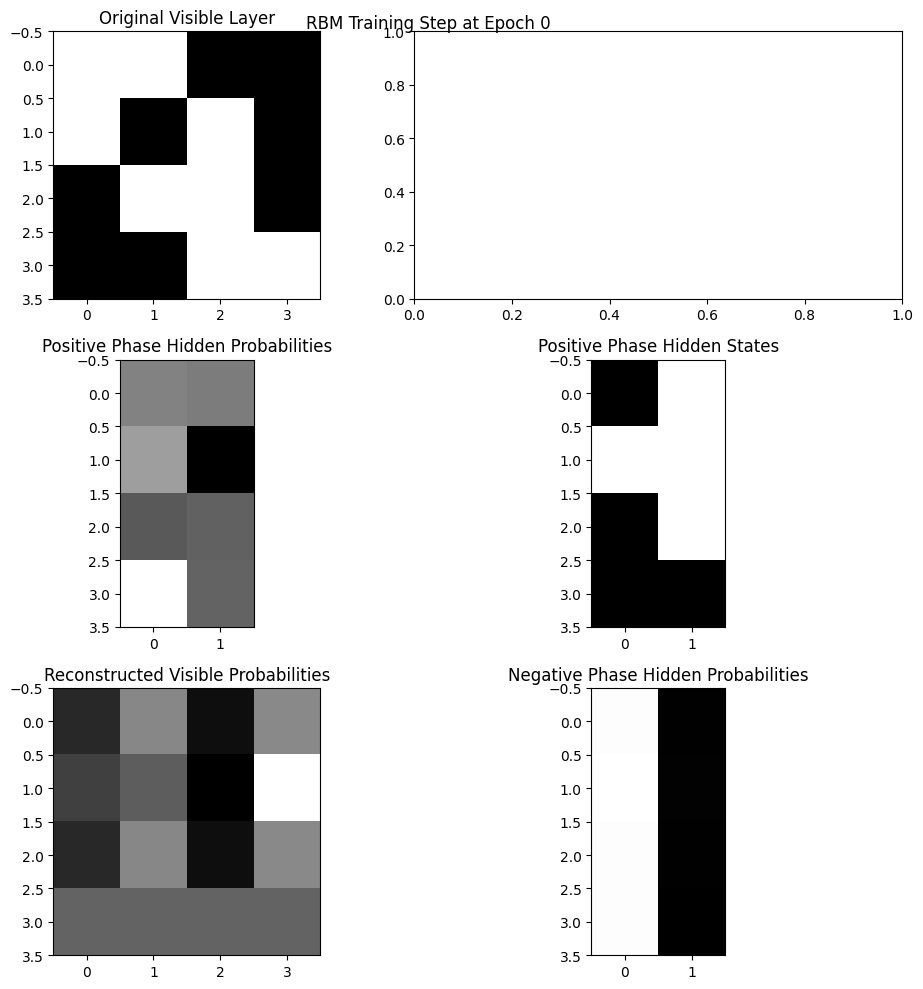

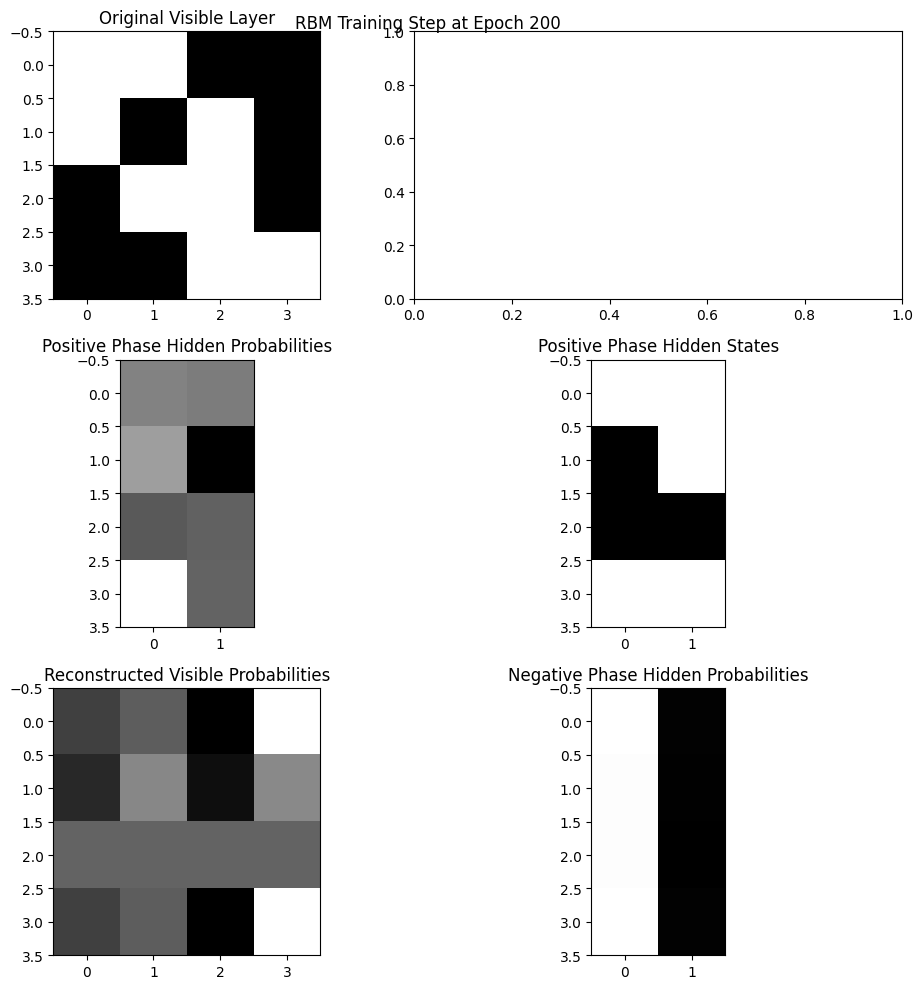

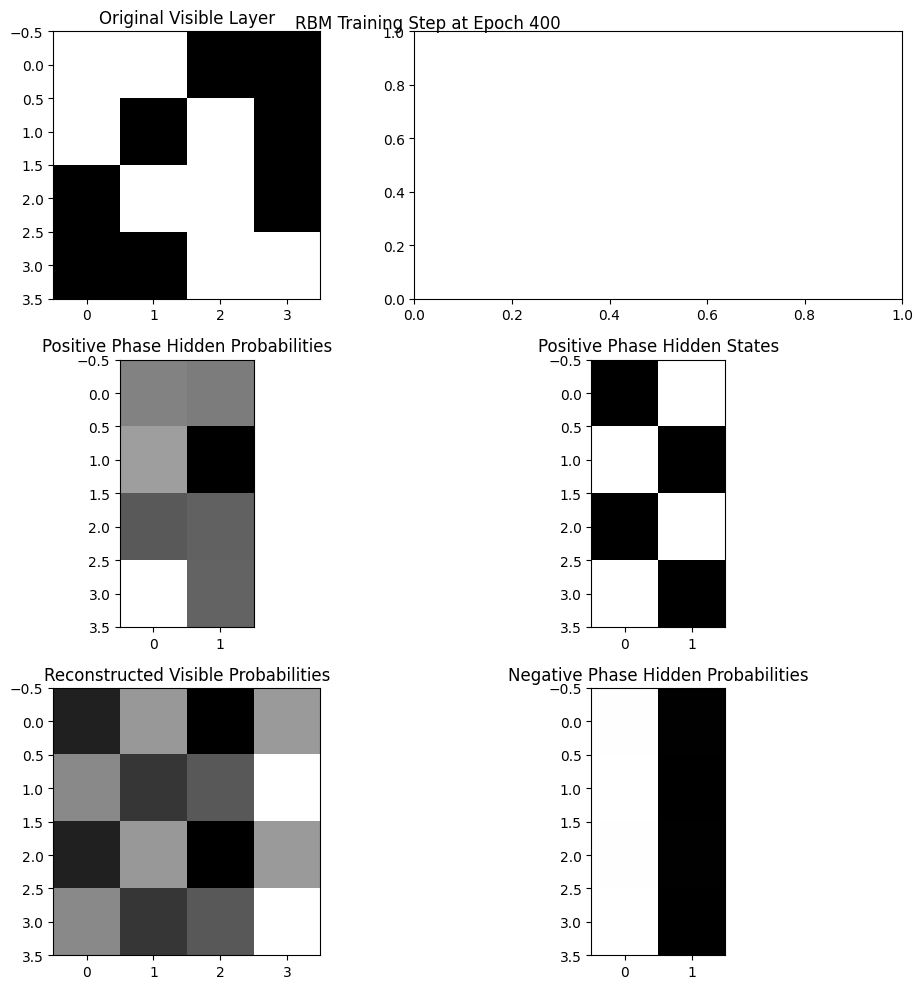

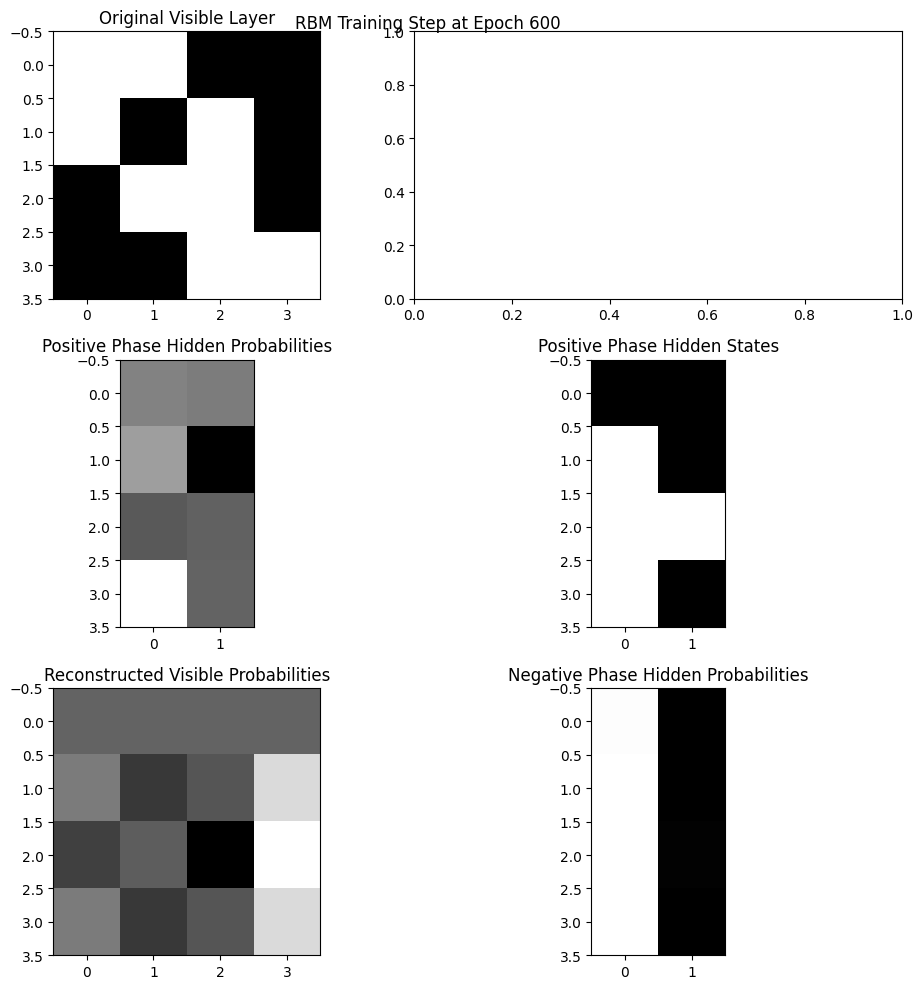

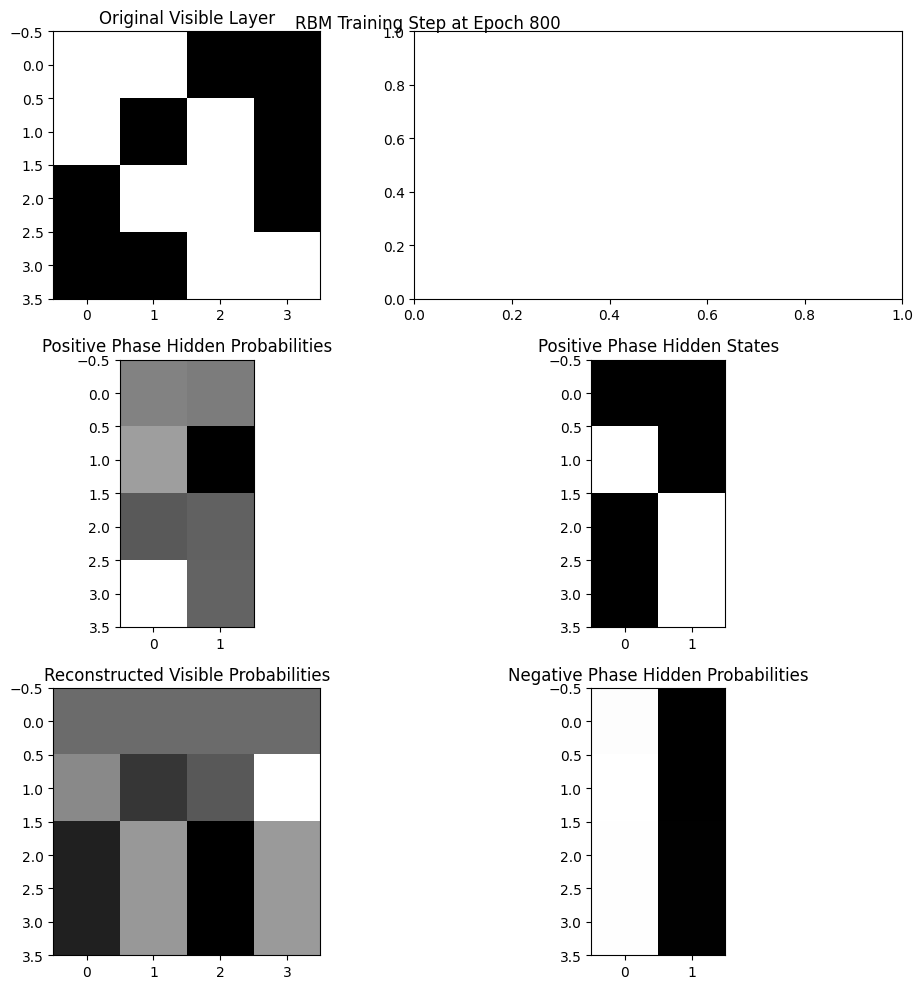

In [20]:
# 创建简单的二进制数据
data = np.array([[1, 1, 0, 0],
                 [1, 0, 1, 0],
                 [0, 1, 1, 0],
                 [0, 0, 1, 1]])

# 创建 RBM 实例
rbm = RBM(visible_units=4, hidden_units=2, learning_rate=0.1)

# 训练过程中每隔一段时间进行可视化
for epoch in range(1000):
    rbm.contrastive_divergence_step(data)
    
    if epoch % 200 == 0:
        rbm.visualize_step(data, epoch)


In [21]:
from manim import *


In [22]:
%%manim -qh -v WARNING RBMVisualization

class RBMVisualization(Scene):
    def construct(self):
        # Step 1: Show Visible Layer (input)
        visible_layer_text = Text("Visible Layer (Input)", font_size=36)
        visible_layer = self.create_layer(num_units=4, layer_name="Visible Layer")
        self.play(Write(visible_layer_text))
        self.play(visible_layer.animate.shift(UP))
        self.play(FadeOut(visible_layer_text))

        # Step 2: Show Hidden Layer (after activation)
        hidden_layer_text = Text("Hidden Layer (Activated)", font_size=36)
        hidden_layer = self.create_layer(num_units=2, layer_name="Hidden Layer")
        self.play(Write(hidden_layer_text))
        self.play(visible_layer.animate.shift(LEFT), hidden_layer.animate.shift(RIGHT))
        self.play(FadeOut(hidden_layer_text))

        # Step 3: Connect visible and hidden layer
        connections = self.connect_layers(visible_layer, hidden_layer)
        self.play(Create(connections))

        # Step 4: Activate Hidden Layer
        self.play(self.activate_layer(hidden_layer))

        # Step 5: Show Reconstructed Visible Layer
        reconstructed_text = Text("Reconstructed Visible Layer", font_size=36)
        reconstructed_layer = self.create_layer(num_units=4, layer_name="Reconstructed Layer")
        self.play(Write(reconstructed_text))
        self.play(hidden_layer.animate.shift(LEFT), reconstructed_layer.animate.shift(RIGHT))
        self.play(FadeOut(reconstructed_text))

        # Step 6: Connect hidden layer to reconstructed visible layer
        recon_connections = self.connect_layers(hidden_layer, reconstructed_layer)
        self.play(Create(recon_connections))

        # Step 7: Animate Reconstruction
        self.play(self.activate_layer(reconstructed_layer))

        # Final step: Pause and display the final state
        self.wait(2)

    def create_layer(self, num_units, layer_name):
        layer = VGroup(*[Circle(radius=0.3, color=BLUE) for _ in range(num_units)])
        layer.arrange(RIGHT, buff=1)
        label = Text(layer_name, font_size=24).next_to(layer, UP)
        return VGroup(layer, label)

    def connect_layers(self, layer1, layer2):
        connections = VGroup()
        for circle1 in layer1[0]:
            for circle2 in layer2[0]:
                connections.add(Line(circle1.get_center(), circle2.get_center()))
        return connections

    def activate_layer(self, layer):
        return Indicate(layer[0], color=YELLOW)



In [23]:
%%manim -qh -v WARNING HopfieldNetworkVisualization

class HopfieldNetworkVisualization(Scene):
    def construct(self):
        # Step 1: Show Input Pattern (binary vector)
        input_pattern_text = Text("Input Pattern", font_size=36)
        input_pattern = self.create_pattern([1, -1, 1, -1])
        self.play(Write(input_pattern_text))
        self.play(input_pattern.animate.shift(UP))
        self.play(FadeOut(input_pattern_text))
        
        # Step 2: Show Hopfield Network and weights
        network_text = Text("Hopfield Network", font_size=36)
        hopfield_network = self.create_hopfield_network()
        self.play(Write(network_text))
        self.play(hopfield_network.animate.shift(DOWN))
        self.play(FadeOut(network_text))
        
        # Step 3: Visualize updating neurons based on the input pattern
        self.update_neurons(input_pattern, hopfield_network)
        
        # Final step: Pause and display the final state
        self.wait(2)

    def create_pattern(self, pattern):
        # Create a binary pattern represented as circles
        nodes = VGroup(*[Circle(radius=0.3, color=BLUE if p == 1 else RED) for p in pattern])
        nodes.arrange(RIGHT, buff=1)
        return nodes

    def create_hopfield_network(self):
        # Create a Hopfield network with 4 neurons
        neurons = VGroup(*[Circle(radius=0.3, color=WHITE) for _ in range(4)])
        neurons.arrange(RIGHT, buff=1)
        return neurons

    def update_neurons(self, pattern, network):
        # Visualize the process of neurons updating
        for i, (neuron, p) in enumerate(zip(network, pattern)):
            self.play(Indicate(neuron, color=YELLOW))
            self.wait(0.5)
            new_color = BLUE if p.get_fill_color() == RED else RED
            neuron.set_fill(new_color)
            self.play(neuron.animate.set_fill(new_color))


In [24]:
%%manim -qh -v WARNING BoltzmannDistribution3D

class BoltzmannDistribution3D(ThreeDScene):
    def construct(self):
        # Step 1: Create Axes
        axes = ThreeDAxes(
            x_range=[0, 5, 1], y_range=[0, 5, 1], z_range=[0, 1, 0.1],
            axis_config={"color": BLUE}
        )

        # Step 2: Define Boltzmann distribution function
        def boltzmann_distribution(x, y):
            k_B = 1  # Assume Boltzmann constant = 1 for simplicity
            return np.exp(-x / (k_B * y))

        # Step 3: Plot the distribution as a surface
        surface = Surface(
            lambda u, v: axes.c2p(u, v, boltzmann_distribution(u, v)),
            u_range=[0, 5], v_range=[1, 5],
            fill_opacity=0.8, checkerboard_colors=[RED, ORANGE]
        )

        # Step 4: Setup camera and animations
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)
        self.add(axes, surface)

        # Step 5: Animate the plot
        self.begin_ambient_camera_rotation(rate=0.1)
        self.wait(5)


In [32]:
%%manim -qh -v WARNING DiscreteBoltzmannDistribution3D

class DiscreteBoltzmannDistribution3D(ThreeDScene):
    def construct(self):
        # Step 1: Create Axes
        axes = ThreeDAxes(
            x_range=[0, 6, 1], y_range=[0, 6, 1], z_range=[0, 1, 0.1],
            axis_config={"color": BLUE}
        )

        # Step 2: Define discrete energy levels and temperatures
        energy_levels = np.array([1, 2, 3, 4, 5])  # Discrete energy levels E_1, E_2, ...
        temperatures = np.linspace(1, 5, 5)        # Discrete temperatures T_1, T_2, ...

        # Step 3: Define Boltzmann distribution function for discrete energy levels
        def boltzmann_prob(E, T):
            k_B = 1  # Simplified Boltzmann constant
            # Calculate the probability distribution for discrete energy levels
            Z = sum(np.exp(-energy_levels / (k_B * T)))  # Partition function
            return np.exp(-E / (k_B * T)) / Z

        # Step 4: Plot bars for each energy level at different temperatures
        bars = VGroup()
        for i, E in enumerate(energy_levels):
            for j, T in enumerate(temperatures):
                prob = boltzmann_prob(E, T)
                bar = self.create_bar(axes, i + 1, T, prob)
                bars.add(bar)

        # Step 5: Add axes and bars to the scene
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)
        self.add(axes, bars)

        # Step 6: Animate the camera rotation
        self.begin_ambient_camera_rotation(rate=0.1)
        self.wait(5)

    def create_bar(self, axes, energy_level, temperature, probability):
        # Create a bar at a specific energy level and temperature with height = probability
        # Determine the center position for the bar
        x = energy_level
        y = temperature
        z = probability / 2  # Center of the bar should be half of its height above z=0

        # Create a cuboid to represent the bar
        bar = Cuboid(
            width=0.5, height=probability, depth=0.5,
            fill_color=BLUE, fill_opacity=0.8
        )
        # Position the bar at the calculated center
        bar.move_to(axes.c2p(x, y, z))
        return bar



NameError: name 'Cuboid' is not defined

In [33]:
%%manim -qh -v WARNING GradientDescent3D

class GradientDescent3D(ThreeDScene):
    def construct(self):
        # Step 1: Create Axes
        axes = ThreeDAxes(
            x_range=[-3, 3, 1],
            y_range=[-3, 3, 1],
            z_range=[0, 10, 2],
            axis_config={"color": BLUE}
        )

        # Step 2: Define the function (e.g., f(x, y) = x^2 + y^2)
        def loss_function(x, y):
            return x**2 + y**2

        # Step 3: Plot the surface
        surface = Surface(
            lambda u, v: axes.c2p(u, v, loss_function(u, v)),
            u_range=[-3, 3],
            v_range=[-3, 3],
            resolution=(25, 25),
            fill_opacity=0.8,
            checkerboard_colors=[BLUE_E, BLUE_D]
        )

        # Step 4: Create the ball (representing the current point in gradient descent)
        ball = Sphere(radius=0.1, color=RED)
        initial_position = axes.c2p(2.5, 2.5, loss_function(2.5, 2.5))
        ball.move_to(initial_position)

        # Step 5: Add axes, surface, and ball to the scene
        self.add(axes, surface, ball)
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)
        
        # Step 6: Simulate gradient descent (simple manual iteration for demo purposes)
        learning_rate = 0.1
        num_steps = 25
        path = [initial_position]  # Store positions for the ball's path

        # Gradient descent updates
        x, y = 2.5, 2.5
        for _ in range(num_steps):
            grad_x = 2 * x  # Gradient of f(x, y) = x^2 + y^2 w.r.t x
            grad_y = 2 * y  # Gradient of f(x, y) = x^2 + y^2 w.r.t y

            # Update x and y based on gradient
            x -= learning_rate * grad_x
            y -= learning_rate * grad_y

            # Calculate new position and add to the path
            new_position = axes.c2p(x, y, loss_function(x, y))
            path.append(new_position)

        # Step 7: Create animation for the ball's movement
        ball_path = VMobject()
        ball_path.set_points_as_corners(path)
        ball_path.set_color(RED)

        self.play(MoveAlongPath(ball, ball_path), run_time=6, rate_func=smooth)

        # Keep the camera rotating during the movement
        self.begin_ambient_camera_rotation(rate=0.1)
        self.wait(5)



In [4]:
%%manim -qh -v WARNING IrregularGradientDescent2D

class IrregularGradientDescent2D(ThreeDScene):
    def construct(self):
        # Step 1: Create Axes
        axes = ThreeDAxes(
            x_range=[-3, 3, 1],
            y_range=[-3, 3, 1],
            z_range=[0, 6, 1],
            axis_config={"color": BLUE}
        ).shift(DOWN*2)

        # Step 2: Define a more complex loss function (irregular surface)
        def loss_function(x, y):
            return np.sin(x) ** 2 + np.cos(y) ** 2 + 0.1 * (x ** 2 + y ** 2)

        # Step 3: Plot the surface
        surface = Surface(
            lambda u, v: axes.c2p(u, v, loss_function(u, v)),
            u_range=[-3, 3],
            v_range=[-3, 3],
            resolution=(100, 100),
            fill_opacity=0.75,
            checkerboard_colors=[RED,ORANGE,YELLOW,GREEN,GREEN_E,BLUE,PURPLE]
        )

        # Step 4: Create the ball (representing the current point in gradient descent)
        ball = Sphere(radius=0.1, color=RED)
        initial_position = axes.c2p(2.5, 2.5, loss_function(2.5, 2.5))
        ball.move_to(initial_position)

        # Step 5: Add axes, surface, and ball to the scene
        self.add(axes, surface, ball)
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)

        # Step 6: Simulate gradient descent (manual iteration)
        learning_rate = 0.1
        num_steps = 25
        path = [initial_position]  # Store positions for the ball's path

        # Gradient descent updates on the irregular surface
        x, y = 2.5, 2.5
        for _ in range(num_steps):
            grad_x = 2 * np.sin(2 * x) + 0.2 * x  # Partial derivative w.r.t. x
            grad_y = -2 * np.sin(2 * y) + 0.2 * y  # Partial derivative w.r.t. y

            # Update x and y based on the gradient
            x -= learning_rate * grad_x
            y -= learning_rate * grad_y

            # Calculate the new position (z-value is from the loss function)
            new_position = axes.c2p(x, y, loss_function(x, y))
            path.append(new_position)

        # Step 7: Create animation for the ball's movement along the path
        ball_path = VMobject()
        ball_path.set_points_as_corners(path)
        ball_path.set_color(RED)

        self.play(MoveAlongPath(ball, ball_path), run_time=6, rate_func=smooth)

        # Keep the camera rotating during the movement
        self.begin_ambient_camera_rotation(rate=0.1)
        self.wait(5)


In [70]:
%%manim -qh -v WARNING SigmoidFunctionPlot

class SigmoidFunctionPlot(Scene):
    @staticmethod
    def get_rectangle_corners(bottom_left, top_right):
        return [
            (top_right[0], top_right[1]),
            (bottom_left[0], top_right[1]),
            (bottom_left[0], bottom_left[1]),
            (top_right[0], bottom_left[1]),
        ]
    
    def construct(self):
        # 定义坐标系
        axes = Axes(
            x_range=[-10, 10, 1],
            y_range=[-0.25, 1.25, 0.5],
            axis_config={
                "color": WHITE,
            },
            y_axis_config={
                "numbers_to_include": np.arange(-0.01, 1.01, 0.5),
                "label_direction": UL*0.8,
            }
        ).scale(0.9).shift(DOWN*0.8)
        
        x_sigmoid = ValueTracker(-10)
        
        def get_rectangle():
            polygon = Polygon(
                *[
                    axes.c2p(*i)
                    for i in self.get_rectangle_corners(
                        (0, 0), (x_sigmoid.get_value(), 1 / (1 + np.exp(-x_sigmoid.get_value())))
                    )
                ]
            )
            polygon.stroke_width = 1
            polygon.set_stroke(WHITE)
            return polygon
        
        polygon = always_redraw(get_rectangle)
        
        # Sigmoid函数
        sigmoid_func = axes.plot(
            lambda x: 1 / (1 + np.exp(-x)),
        ).set_color_by_gradient(rainbow_color)

        # 添加标签
        sigmoid_label = MathTex(r"sigmoid : \sigma(x) = \frac{1}{1 + e^-x}").next_to(sigmoid_func, UP*6.5)
        
        # vgp = VGroup(axes, sigmoid_func, sigmoid_label)
        
        x_value = always_redraw(lambda: Text(f"x = {round(x_sigmoid.get_value(), 2)}").shift(UP*0.5,LEFT*3))
        y_value = always_redraw(lambda: Text(f"y = {round(1 / (1 + np.exp(-x_sigmoid.get_value())), 4)}").shift(DOWN*0.5,LEFT*3))
        
        
        self.play(Create(axes), run_time=2)
        self.play(Create(sigmoid_func), run_time=2)
        
        self.play(Write(sigmoid_label),run_time=2)

        self.wait()
        
        dot = Dot()
        dot.add_updater(lambda x: x.move_to(axes.c2p(
            x_sigmoid.get_value(),  1 / (1 + np.exp(-x_sigmoid.get_value())))
        ))
        dot.set_z_index(10)
        
        self.play(Create(polygon),Create(dot),Create(x_value),Create(y_value))
        self.wait()
        def rate_t(t):
            return t**2 * (3 - 2*t)
            
        self.play(x_sigmoid.animate.set_value(10),run_time=5,rate_func=rate_t)
        self.wait()


In [6]:
%%manim -qh -v WARNING NormalFunctionPlot

class NormalFunctionPlot(Scene):
    @staticmethod
    def get_rectangle_corners(bottom_left, top_right):
        return [
            (top_right[0], top_right[1]),
            (bottom_left[0], top_right[1]),
            (bottom_left[0], bottom_left[1]),
            (top_right[0], bottom_left[1]),
        ]
    
    def construct(self):
        axe_min = -5
        axe_max = 5
        
        # 定义坐标系
        axes = Axes(
            x_range=[axe_min, axe_max, 1],
            y_range=[0, 0.5, 0.1],
            axis_config={
                "color": WHITE,
            },
            y_axis_config={
                "numbers_to_include": np.arange(-0.01, 0.41, 0.4),
                "label_direction": UL*0.8,
            }
        ).scale(0.9).shift(DOWN*0.8)
        
        x_normal = ValueTracker(axe_min)
        
        def get_rectangle():
            polygon = Polygon(
                *[
                    axes.c2p(*i)
                    for i in self.get_rectangle_corners(
                        (0, 0), (x_normal.get_value(), (1 / (1 * (2 * PI)**0.5)) * np.exp(-0.5 * x_normal.get_value()**2))
                    )
                ]
            )
            polygon.stroke_width = 1
            polygon.set_stroke(WHITE)
            return polygon
        
        polygon = always_redraw(get_rectangle)
        
        # Sigmoid函数
        normal_func = axes.plot(
            lambda x: (1 / (1 * (2 * PI)**0.5)) * np.exp(-0.5 * x**2),
        ).set_color_by_gradient(rainbow_color)

        # 添加标签
        sigmoid_label = MathTex(r"f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)").next_to(normal_func, UP*6.5)
        
        # vgp = VGroup(axes, sigmoid_func, sigmoid_label)
        
        x_value = always_redraw(lambda: Text(f"x = {round(x_normal.get_value(), 2)}").shift(UP*0.5,LEFT*4))
        y_value = always_redraw(lambda: Text(f"f(x) = {round((1 / (1 * (2 * PI)**0.5)) * np.exp(-0.5 * x_normal.get_value()**2), 2)}").shift(DOWN*0.5,LEFT*4))
        
        def rate_t(t):
            return t**2 * (3 - 2*t)
        
        self.play(Create(axes), run_time=2)
        self.play(Create(normal_func), run_time=4,rate_functions=rate_t)
        
        self.play(Write(sigmoid_label),run_time=2)

        self.wait()
        
        # dot = Dot()
        # dot.add_updater(lambda x: x.move_to(axes.c2p(
        #     x_normal.get_value(),  (1 / (1 * (2 * PI)**0.5)) * np.exp(-0.5 * x_normal.get_value()**2))
        # ))
        # dot.set_z_index(10)
        # 
        # self.play(Create(polygon),Create(dot),Create(x_value),Create(y_value))
        # self.wait()
        #     
        # self.play(x_normal.animate.set_value(axe_max),run_time=5,rate_func=linear)
        # self.wait()


In [2]:
%%manim -qh -v WARNING ParametricCurveWithVectors

class ParametricCurveWithVectors(ThreeDScene):
    def construct(self):
        # 设置3D坐标轴
        axes = ThreeDAxes(
            x_range=[0, 3, 1], y_range=[0, 3, 1], z_range=[0, 10, 2],
            x_length=6, y_length=6, z_length=6
        )
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES)

        # 定义参数化曲线
        t_values = np.linspace(0, 1.5, 20)
        x_values = t_values**2
        y_values = (2/3) * t_values**3
        z_values = (6/4) * t_values**4 - (1/3) * t_values**3

        # 定义向量箭头的方向，反向箭头
        Vx = -np.gradient(x_values)
        Vy = -np.gradient(y_values)
        Vz = -np.gradient(z_values)

        # 绘制3D曲线
        curve = VGroup()
        for i in range(1, len(t_values)):
            # 添加曲线段
            line_segment = Line3D(
                start=axes.c2p(x_values[i-1], y_values[i-1], z_values[i-1]),
                end=axes.c2p(x_values[i], y_values[i], z_values[i]),
                color=RED
            )
            curve.add(line_segment)

        # 创建箭头
        vectors = VGroup()
        for i in range(len(t_values)):
            vector = Arrow3D(
                start=axes.c2p(x_values[i], y_values[i], z_values[i]),
                end=axes.c2p(x_values[i] + Vx[i], y_values[i] + Vy[i], z_values[i] + Vz[i]),
                color=BLUE
            )
            vectors.add(vector)

        # 动画依次绘制曲线和箭头
        self.add(axes)
        self.play(Create(curve), run_time=4)
        self.play(Create(vectors), run_time=2)
        self.wait()


[10/10/24 08:56:09] WARNING  It looks like the scene contains a lot of sub-mobjects. Caching is      ]8;id=974155;file://E:\ipynb\venv\lib\site-packages\manim\utils\hashing.py\hashing.py]8;;\:]8;id=157541;file://E:\ipynb\venv\lib\site-packages\manim\utils\hashing.py#158\158]8;;\
                             sometimes not suited to handle such large scenes, you might consider                  
                             disabling caching with --disable_caching to potentially speed up the                  
                             rendering process.                                                                    

                    WARNING  You can disable this warning by setting disable_caching_warning to True ]8;id=561480;file://E:\ipynb\venv\lib\site-packages\manim\utils\hashing.py\hashing.py]8;;\:]8;id=700859;file://E:\ipynb\venv\lib\site-packages\manim\utils\hashing.py#164\164]8;;\
                             in your config file.                                                                  

KeyboardInterrupt: 

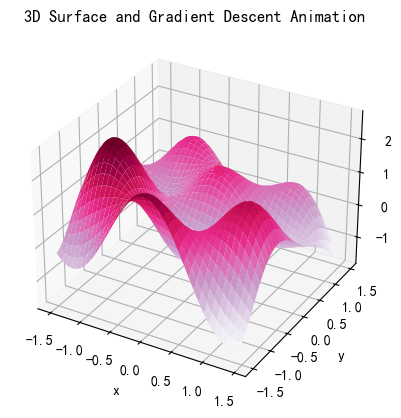

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定义 x 和 y 的取值范围
x, y = np.meshgrid(np.arange(-1.5, 1.5, 0.04), np.arange(-1.5, 1.5, 0.04))
z = np.sin(x**2 + y**2) + np.cos(3*x) * np.sin(3*y) - 0.35 * x - 0.3 * y

# 绘制三维曲面
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap="PuRd")
plt.colorbar(surf)
ax.set_title('3D Surface and Gradient Descent Animation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# 定义梯度下降参数
learning_rate = 0.1  # 学习率
num_iterations = 300  # 迭代次数

# 选择起始点
start_x = 0
start_y = 0.5

# 初始化当前位置
current_x = start_x
current_y = start_y

# 获取当前点的初始z值
current_z = np.sin(current_x**2 + current_y**2) + np.cos(3*current_x) * np.sin(3*current_y) + 0.2

# 存储梯度下降路径
path_x = [current_x]
path_y = [current_y]
path_z = [current_z]

# 动画循环：梯度下降过程
# 计算梯度
gx, gy = np.gradient(z)
    
# 找到当前点的索引
x_index = (np.abs(x[0, :] - current_x)).argmin()
y_index = (np.abs(y[:, 0] - current_y)).argmin()
    
# 获取当前点的梯度
grad_x = gx[y_index, x_index]
grad_y = gy[y_index, x_index]
    
# 更新当前位置
current_x = current_x - learning_rate * grad_x
current_y = current_y - learning_rate * grad_y
current_z = np.sin(current_x**2 + current_y**2) + np.cos(3*current_x) * np.sin(3*current_y)
    
# 记录路径
path_x.append(current_x)
path_y.append(current_y)
path_z.append(current_z)
    
# 更新绘制路径
ax.plot(path_x, path_y, path_z, 'r-', linewidth=2)
ax.scatter(current_x, current_y, current_z, color='r', s=50)

plt.show()


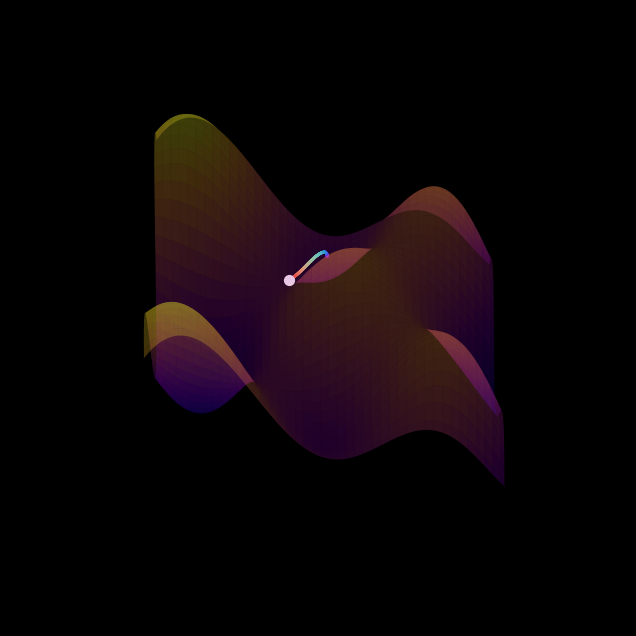

In [63]:
# 定义 x 和 y 的取值范围
x, y = np.meshgrid(np.arange(-1.25, 1.25, 0.03), np.arange(-0.75, 1.75, 0.03))
z = np.sin(x**2 + y**2) + np.cos(3*x) * np.sin(3*y)

# 绘制三维曲面
fig = plt.figure(figsize=(10, 8), dpi=100)
fig.patch.set_facecolor('black')
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap="plasma", alpha=0.5)
ax.grid(False)

# 定义梯度下降参数
learning_rate = 0.05  # 学习率
num_iterations = 300  # 迭代次数
noise_factor = 0.01   # 随机扰动系数，帮助跳出局部最优

# 选择起始点
start_x = 0
start_y = 0.5

# 初始化当前位置
current_x = start_x
current_y = start_y

# 获取当前点的初始z值
current_z = np.sin(current_x**2 + current_y**2) + np.cos(3*current_x) * np.sin(3*current_y) + 0.1

# 存储梯度下降路径
path_x = [current_x]
path_y = [current_y]
path_z = [current_z]

# 动画更新函数
def update(i):
    global current_x, current_y, current_z , path_x, path_y, path_z
    
    if i % 200 == 0:
        # 初始化当前位置
        current_x = start_x
        current_y = start_y

        # 获取当前点的初始z值
        current_z = np.sin(current_x**2 + current_y**2) + np.cos(3*current_x) * np.sin(3*current_y) + 0.1

        # 存储梯度下降路径
        path_x = [current_x]
        path_y = [current_y]
        path_z = [current_z]
    
    # 清除之前的路径绘制
    ax.cla()
    # 重新绘制曲面
    ax.plot_surface(x, y, z, cmap="plasma", alpha=0.25)
    ax.grid(False)
    ax.set_facecolor('none')
    ax.set_axis_off()
    
    # 设置旋转角度，每次更新旋转方位角 `azim`
    ax.view_init(elev=40 + 18 * np.sin(np.pi/num_iterations * i), azim=i*360/(4*num_iterations))  # 每次更新旋转
    
    # 计算梯度
    gx, gy = np.gradient(z)
    
    # 找到当前点的索引
    x_index = (np.abs(x[0, :] - current_x)).argmin()
    y_index = (np.abs(y[:, 0] - current_y)).argmin()
    
    # 获取当前点的梯度
    grad_x = gx[y_index, x_index]
    grad_y = gy[y_index, x_index]
    
    # 引入随机扰动，帮助跳出局部最优
    noise_x = np.random.uniform(-noise_factor, noise_factor)
    noise_y = np.random.uniform(-noise_factor,noise_factor)
    
    # 更新当前位置
    current_x = current_x - learning_rate * grad_x
    current_y = current_y - learning_rate * grad_y
    current_z = np.sin(current_x**2 + current_y**2) + np.cos(3*current_x) * np.sin(3*current_y)  + 0.1
    
    # 记录路径
    path_x.append(current_x)
    path_y.append(current_y)
    path_z.append(current_z)
    
    # 使用颜色映射为路径分配彩虹色
    norm = plt.Normalize(0, len(path_x))  # 标准化索引，用于颜色映射
    colors = cm.rainbow(norm(range(len(path_x))))  # 获取彩虹色列表
    
    for j in range(len(path_x) - 1):
        ax.plot(path_x[j:j+2], path_y[j:j+2], path_z[j:j+2], color=colors[j], linewidth=2)
    
    ax.scatter(current_x, current_y, current_z, color='w', s=50)

# 使用 FuncAnimation 创建动画
ani = FuncAnimation(fig, update, frames=num_iterations*4, repeat=False, interval=15)
ani.save(r'E:\ipynb\media\videos\tf\test.mp4', writer='ffmpeg')
# 展示动画
plt.show()


In [71]:
%%manim -qh -v WARNING MatrixStepwiseAddition

class MatrixStepwiseAddition(Scene):
    def construct(self):
        # 创建两个矩阵 A 和 B
        matrix_a = Matrix([[1, 2], [3, 4]])
        matrix_b = Matrix([[5, 6], [7, 8]])

        # 将两个矩阵放置在场景中
        matrix_a.next_to(ORIGIN, LEFT)
        matrix_b.next_to(ORIGIN, RIGHT)

        # 创建加号
        plus = MathTex("+").next_to(matrix_a, RIGHT)

        # 创建等号
        equal = MathTex("=").next_to(matrix_b, RIGHT)

        # 初始化一个空矩阵，用于显示计算结果
        result_matrix = Matrix([["?", "?"], ["?", "?"]])
        result_matrix.next_to(equal, RIGHT)

        # 将矩阵 A、B、加号、等号以及结果矩阵加入场景
        self.play(Write(matrix_a), Write(matrix_b), Write(plus), Write(equal), Write(result_matrix))

        # 分步展示矩阵加法的计算过程
        step_1 = Matrix([[1+5, "?", "?", "?"]]).next_to(equal, RIGHT)
        self.play(Transform(result_matrix, step_1))
        self.wait(1)

        step_2 = Matrix([[1+5, 2+6, "?", "?"]]).next_to(equal, RIGHT)
        self.play(Transform(result_matrix, step_2))
        self.wait(1)

        step_3 = Matrix([[1+5, 2+6, 3+7, "?"]]).next_to(equal, RIGHT)
        self.play(Transform(result_matrix, step_3))
        self.wait(1)

        step_4 = Matrix([[1+5, 2+6, 3+7, 4+8]]).next_to(equal, RIGHT)
        self.play(Transform(result_matrix, step_4))
        self.wait(1)

        # 最后显示最终计算结果
        final_result = Matrix([[1+5, 2+6], [3+7, 4+8]]).next_to(equal, RIGHT)
        self.play(Transform(result_matrix, final_result))
        self.wait(2)


迭代 0: 损失: 0.24706377602736884
迭代 100: 损失: 0.167011331224926
迭代 200: 损失: 0.16345614907804537
迭代 300: 损失: 0.16038223060565268
迭代 400: 损失: 0.15549208596051167
迭代 500: 损失: 0.1547929544923122
迭代 600: 损失: 0.1553290504594777
迭代 700: 损失: 0.1530157416234908
迭代 800: 损失: 0.1573468841993684
迭代 900: 损失: 0.15548572451550977


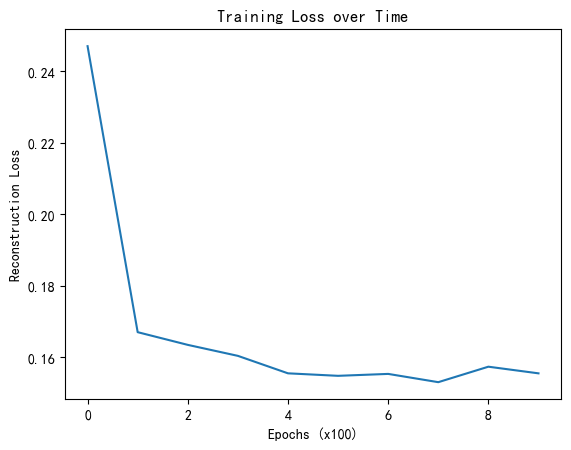

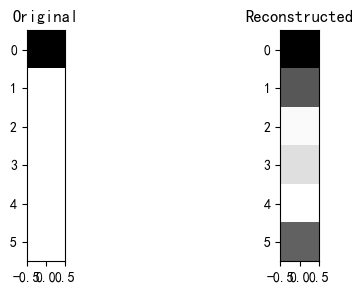

In [13]:
# 假设我们之前已经定义并训练了 RBM
rbm = RBM(visible_units=6, hidden_units=3, learning_rate=0.1)

# 模拟一些输入数据
data = np.random.binomial(1, 0.5, size=(100, 6))

# 训练模型，并获取损失值
loss_list = rbm.train(data, epochs=1000)

# 可视化损失函数
plt.plot(loss_list)
plt.xlabel('Epochs (x100)')
plt.ylabel('Reconstruction Loss')
plt.title('Training Loss over Time')
plt.show()

# 使用原始数据进行重构
reconstructed_data = rbm.reconstruct(data)

# 对比第一个样本的原始和重构结果
def plot_images(original, reconstructed, index=0):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # 原始数据
    axes[0].imshow(original[index].reshape(6, 1), cmap='gray')
    axes[0].set_title('Original')

    # 重构数据
    axes[1].imshow(reconstructed[index].reshape(6, 1), cmap='gray')
    axes[1].set_title('Reconstructed')

    plt.show()

plot_images(data, reconstructed_data)


In [ ]:
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        # 初始化可见层和隐藏层的单元数量，以及学习率
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        # 权重矩阵初始化，正态分布随机权重
        # W_ij: 权重矩阵，用于连接可见单元v_i和隐藏单元h_j
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))

        # 初始化可见层和隐藏层的偏置
        # b_i: 可见层偏置，c_j: 隐藏层偏置
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

    def sigmoid(self, x):
        # 激活函数使用sigmoid，表示状态概率
        # σ(x) = 1 / (1 + exp(-x))，用于将线性组合结果转为概率
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        # 采样隐藏层状态
        # P(h_j = 1 | v) = σ(Σ(v_i * W_ij) + c_j)
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        # 根据概率采样隐藏单元的状态
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        # 采样可见层状态
        # P(v_i = 1 | h) = σ(Σ(h_j * W_ij) + b_i)
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        # 根据概率采样可见单元的状态
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        # 正向传播：采样隐藏单元的概率和状态
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        # 正向传播：计算正项关联项 Σ(v_i * h_j)_data
        # 正关联项 pos_associations = v^T * P(h|v)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # 重构可见层：通过隐藏层采样重构的可见单元
        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        # 反向传播：通过重构后的可见层再次采样隐藏单元
        # 负项关联项 Σ(v_i * h_j)_model
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # 更新权重矩阵
        # ΔW_ij = η * (Σ(v_i * h_j)_data - Σ(v_i * h_j)_model)
        self.weights += self.learning_rate * (pos_associations - neg_associations)

        # 更新可见层和隐藏层的偏置
        # Δb_i = η * (v_data - v_model)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        # Δc_j = η * (h_data - h_model)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data, epochs=1000):
        loss_list = []
        for epoch in range(epochs):
            # 每轮训练执行对比散度
            self.contrastive_divergence(data)
            if epoch % 100 == 0:
                # 计算损失（均方误差）用于监控训练过程
                loss = np.mean((data - self.sample_visible(self.sample_hidden(data)[1])[0])**2)
                loss_list.append(loss)
                print(f'迭代 {epoch}: 损失: {loss}')

        return loss_list

    def reconstruct(self, data):
        # 重构输入数据
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible


In [203]:
import numpy as np

class RBMMovie:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        # 权重初始化为随机值
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data, epochs=1000):
        for epoch in range(epochs):
            self.contrastive_divergence(data)

    def predict(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible

# 模拟用户对电影的评分数据
# 行代表用户，列代表电影，1 表示喜欢，0 表示不喜欢
user_movie_ratings = np.array(like_hood_list)

# 创建 RBM 模型
rbm = RBMMovie(visible_units=5, hidden_units=3)
rbm.train(user_movie_ratings, epochs=5000)

# 预测某个用户的电影喜好
new_user = np.array([[1, 0, 0, 0, 0]])  # 新用户的观影历史
predicted_ratings = rbm.predict(new_user)
print(f"预测的电影偏好: {predicted_ratings}")


预测的电影偏好: [[9.99963749e-01 9.93367981e-01 5.01923106e-05 1.82239281e-05
  5.25196586e-03]]


概率质量函数
\begin{equation}
P(X = k) = \binom{n}{k} p^k (1 - p)^{n - k}
\end{equation}

组合数
\begin{equation}
\binom{n}{k} = \frac{n!}{k!(n-k)!}
\end{equation}

Restricted Boltzmann Machine (RBM)

能量函数
\begin{equation}
E(v, h) = - \sum_{i,j} v_i W_{ij} h_j - \sum_i b_i v_i - \sum_j c_j h_j
\end{equation}

隐藏层状态采样
\begin{equation}
P(h_j = 1 | v) = \sigma\left(\sum_i v_i W_{ij} + c_j\right)
\end{equation}

可见层状态采样
\begin{equation}
P(v_i = 1 | h) = \sigma\left(\sum_j h_j W_{ij} + b_i\right)
\end{equation}

对比散度权重更新
\begin{equation}
\Delta W_{ij} = \eta \left( \langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{model}} \right)
\end{equation}

可见层偏置更新
\begin{equation}
\Delta b_i = \eta \left( \langle v_i \rangle_{\text{data}} - \langle v_i \rangle_{\text{model}} \right)
\end{equation}

隐藏层偏置更新
\begin{equation}
\Delta c_j = \eta \left( \langle h_j \rangle_{\text{data}} - \langle h_j \rangle_{\text{model}} \right)
\end{equation}

Sigmoid 函数
\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation}


In [241]:

%%manim -qh -v WARNING TextRequire
"""
class TextRequire(Scene):
    def construct(self):
        hidden_text = SingleStringMathTex(r"P(v_i = 1 | h) = \sigma\left(\sum_j h_j W_{ij} + b_i\right)")
        self.play(Write(hidden_text))
        self.wait()
        
        def play_inter(text_mob,style,wait_time = 2):
            self.play(text_mob.animate.set_color(style))
            self.play(Indicate(text_mob,color=style,run_time=wait_time))
            self.wait(wait_time)
        
        hidden_times = hidden_text[13:-2]
        play_inter(hidden_times,YELLOW_B)
        
        hidden_sigma = VGroup(hidden_text[10:13], hidden_text[-2:])
        play_inter(hidden_sigma,GREEN_B)
        
        hidden_bin = hidden_text[:9]
        play_inter(hidden_bin,BLUE_B)

"""

"""
%%manim -qh -v WARNING TextRequire

class TextRequire(Scene):
    def construct(self):
        w_text = SingleStringMathTex(r"E(v, h) = - \sum_{i,j} v_i W_{ij} h_j - \sum_i b_i v_i - \sum_j c_j h_j")
        wij_text = w_text[14:17]
        vi_text = VGroup(w_text[2],w_text[12:14],w_text[24:26])
        hj_text = VGroup(w_text[4],w_text[17:19],w_text[-2:])
        bi_text = w_text[22:24]
        cj_text = w_text[-4:-2]
        
        self.play(Write(w_text))
        self.wait()

        def play_inter(text_mob,style,wait_time = 2, mode = 'single'):
            self.play(text_mob.animate.set_color(style))
            if mode == 'vgp':
                animations = [Indicate(element, color=style, run_time=wait_time) for element in text_mob]
                self.play(AnimationGroup(*animations))
            else:
                self.play(Indicate(text_mob,color=style,run_time=wait_time))
            self.wait(wait_time)

        play_inter(wij_text,LIGHT_BROWN)
        play_inter(vi_text,GREEN_B,mode='vgp')
        play_inter(hj_text,BLUE_B,mode='vgp')
        play_inter(bi_text,YELLOW_B)
        play_inter(cj_text,PURPLE_B)

"""

In [88]:
%%manim -qh -v WARNING TextRequire

class TextRequire(Scene):
    def construct(self):
        delta_text = VGroup(
            SingleStringMathTex(r"\Delta W_{ij} = \eta \left( \langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{model}})"),
            SingleStringMathTex(r"\Delta b_i = \eta \left( \langle v_i \rangle_{\text{data}} - \langle v_i \rangle_{\text{model}} \right)"),
            SingleStringMathTex(r"\Delta c_j = \eta \left( \langle h_j \rangle_{\text{data}} - \langle h_j \rangle_{\text{model}} \right)"),
        ).arrange(DOWN,buff=0.75)
        delta_text[0].set_color(YELLOW_B)
        delta_text[1].set_color(GREEN_B)
        delta_text[2].set_color(BLUE_B)
        for i in range(len(delta_text)):
            self.play(Write(delta_text[i],run_time=3))
            self.wait(1.5)
            
        self.wait()


In [165]:
%%manim -qh -v WARNING TableLikeHood
from squ_tex import SquTex

class TableLikeHood(Scene):
    def construct(self):
        picture_logo = Group(
            ImageMobject(r"E:\ipynb\media\nobel_prize\cs2.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\buff.jpg").scale(32/447),
            ImageMobject(r"E:\ipynb\media\nobel_prize\dota2.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\jdqs.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\pvz.jpg"),
        ).scale(2).arrange(buff=0.51).shift(UP*3)
        picture_human = Group(
            ImageMobject(r"E:\ipynb\media\nobel_prize\htt.jpg").scale(64/474),
            ImageMobject(r"E:\ipynb\media\nobel_prize\hyj.jpg").scale(64/274),
            ImageMobject(r"E:\ipynb\media\nobel_prize\nyy.jpg").scale(64/300),
            ImageMobject(r"E:\ipynb\media\nobel_prize\zzm.jpg").scale(64/300),
            ImageMobject(r"E:\ipynb\media\nobel_prize\jkg.webp").scale(64/500),
        ).scale(2.1).arrange(DOWN,buff=0).shift(LEFT*3)
        member = VGroup(
            SquTex("√√√ √",**type_dict_like["b"]),
            SquTex("√√   ",**type_dict_like["b"]),
            SquTex("√  √ ",**type_dict_like["b"]),
            SquTex("    √",**type_dict_like["b"]),
            SquTex("  √√ ",**type_dict_like["b"]),
        ).scale(0.5).arrange(DOWN,buff=0)
        self.wait()
        for i in range(len(picture_logo)):
            self.play(FadeIn(picture_logo[i]),run_time=0.3)
        self.wait()
        for i in range(len(picture_human)):
            self.play(FadeIn(picture_human[i]),run_time=0.3)
        self.wait()
        self.play(Create(member),runtime = 2)
        self.wait(2)
        for i in range(5):
            list_j = []
            for j in range(5):
                if like_hood_list[i][j] == 1:
                    list_j.append(j)
            self.play(member[i].animate.change_square(*list_j,color = rainbow_color5[i],),rum_time = 0.2)
            
        self.wait()
        

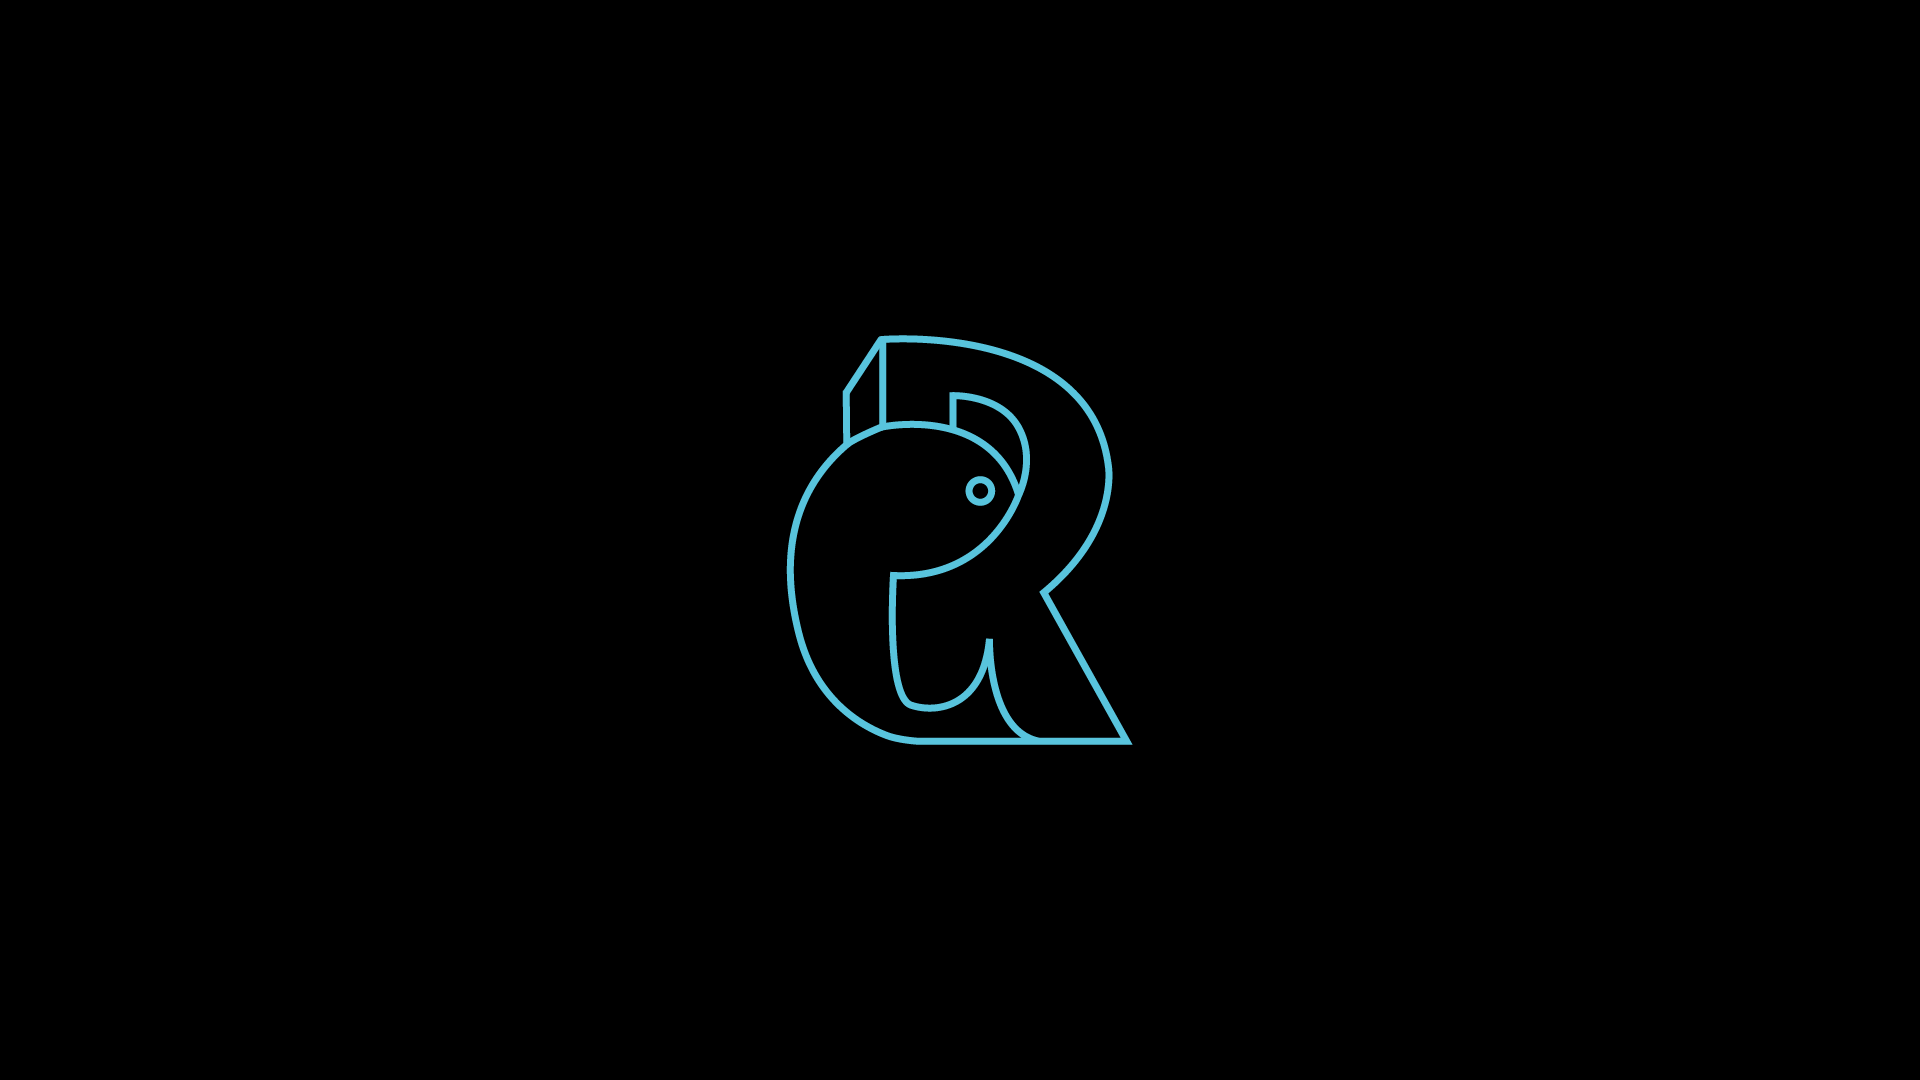

In [283]:
%%manim -qh -v WARNING LOGO
class LOGO(Scene):
    def construct(self):
        logo = ImageMobject(r"C:\Users\rainbow_yu\Desktop\logo.png").set_color(BLUE)
        
        self.add(logo)

In [164]:
%%manim -qh -v WARNING LikeHoodMatrix
class LikeHoodMatrix(Scene):
    def construct(self):
        matrix = Matrix(like_hood_list)
        for i in range(5):
            for j in range(5):
                if like_hood_list[i][j] == 1:
                    matrix[0][j+i*5].set_color(rainbow_color5[i])
        
        self.play(Create(matrix),run_time = 3)
        self.wait(0.5)
        self.play(FadeOut(matrix),run_time = 0.5)
        
        s_martrix = VGroup()
        for i in range(5):
            s = SquTex(like_hood_list[i],**type_dict_like["m_n"]).scale(0.5)
            list_j_y = []
            list_j_n = []
            for j in range(5):
                if like_hood_list[i][j] == 1:
                    list_j_y.append(j)
                else:
                    list_j_n.append(j)
            s.change_square(*list_j_y,color = WHITE)
            s.change_square(*list_j_n,color = BLACK)
            s.change_text(*list_j_y,color = BLACK)
            s_martrix.add(s)
        s_martrix.arrange(DOWN,buff=0)
        s_martrix.add(SurroundingRectangle(s_martrix,buff=0).set_color(WHITE))
        
        self.play(FadeIn(s_martrix),run_time = 2)
        self.wait()
        

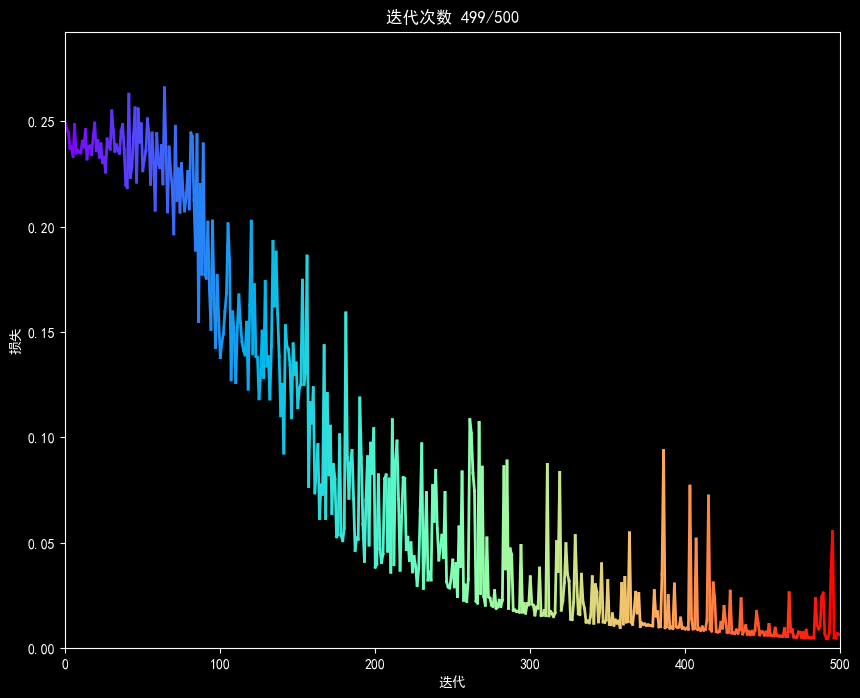

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm

class RBMMovie:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1, n_iter=1000):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.n_iter = n_iter

        # 权重初始化为随机值
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

        # 存储每个epoch的损失
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # 更新权重和偏置
        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        # 计算和记录损失
        loss = np.mean((data - neg_visible_probs) ** 2)
        self.errors.append(loss)

    def train(self, data):
        for _ in range(self.n_iter):
            self.contrastive_divergence(data)

    def predict(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible

# 模拟用户对电影的评分数据
user_movie_ratings = np.array(like_hood_list)

# 创建 RBM 模型
rbm = RBMMovie(visible_units=5, hidden_units=5, n_iter=500)
rbm.train(user_movie_ratings)

# 创建绘图窗口
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')
ax.set_xlim(0, rbm.n_iter)
ax.set_ylim(0, max(rbm.errors) * 1.1)
ax.set_xlabel('迭代', color='white')
ax.set_ylabel('损失', color='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# 动态绘制曲线时使用颜色映射
norm = plt.Normalize(0, rbm.n_iter)  # 标准化帧数
colors = cm.rainbow(norm(np.arange(rbm.n_iter)))  # 获取彩虹色数组

lines = [ax.plot([], [], color=colors[i], lw=2)[0] for i in range(rbm.n_iter - 1)]

def update(frame):
    """更新函数：为每一段曲线分配颜色并更新数据"""
    for i in range(frame):
        lines[i].set_data([i, i + 1], [rbm.errors[i], rbm.errors[i + 1]])
    
    # 在标题处动态显示当前训练次数
    ax.set_title(f'迭代次数 {frame}/{rbm.n_iter}', color='white')
    return lines

# 动态绘制彩虹色损失曲线
ani = FuncAnimation(fig, update, frames=rbm.n_iter, repeat=False, interval=30)

# 保存动画
ani.save(r'E:\ipynb\media\videos\tf\test.mp4', writer='ffmpeg')

plt.show()


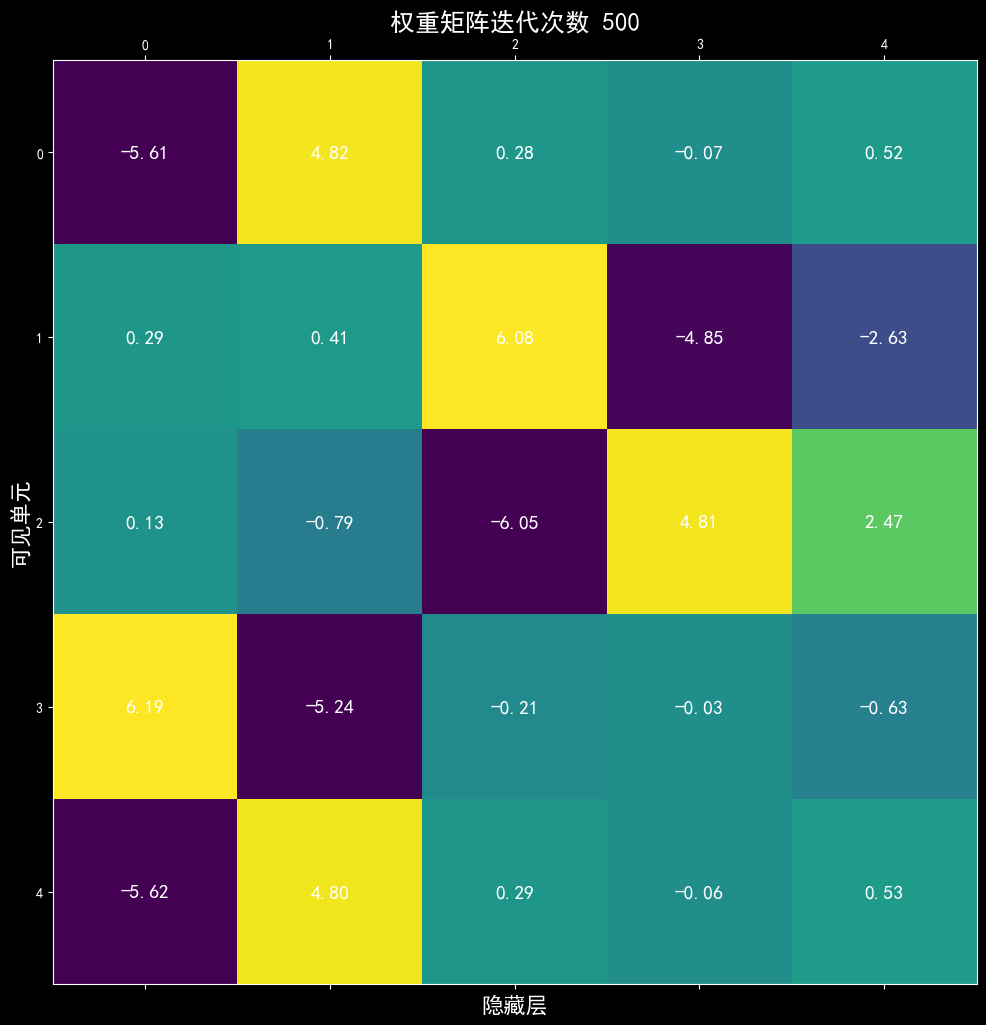

In [281]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class RBMMovie:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        loss = np.mean((data - neg_visible_probs) ** 2)
        self.errors.append(loss)

    def train(self, data, epochs=1000):
        for epoch in range(epochs):
            self.contrastive_divergence(data)

    def predict(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible

# 模拟用户对电影的评分数据
user_movie_ratings = np.array(like_hood_list)

# 创建 RBM 模型并训练
rbm = RBMMovie(visible_units=5, hidden_units=5)
rbm.train(user_movie_ratings, epochs=500)

# 设置绘图参数
fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
cax = ax.matshow(rbm.weights, cmap='viridis', vmin=-5, vmax=5)
ax.set_title('权重矩阵', color='white', fontsize=20)  # 设置标题字体大小
plt.xlabel('隐藏层', color='white', fontsize=16)
plt.ylabel('可见单元', color='white', fontsize=16)

fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# 添加文本标注
texts = np.empty(rbm.weights.shape, dtype=object)

def update(frame):
    """更新函数：根据训练迭代更新权重矩阵及文本标注"""
    rbm.train(user_movie_ratings, epochs=1)
    cax.set_array(rbm.weights)

    # 更新文本标注并放大字体
    for (i, j), val in np.ndenumerate(rbm.weights):
        if texts[i, j] is None:
            texts[i, j] = ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                                  color='white', fontsize=14)  # 设置字体大小
        else:
            texts[i, j].set_text(f'{val:.2f}')
            texts[i, j].set_color('white')  # 保持字体颜色一致

    ax.set_title(f'权重矩阵迭代次数 {frame + 1}', fontsize=18)  # 动态更新标题字体大小
    return cax,

# 创建动画
ani = FuncAnimation(fig, update, frames=500, interval=30, repeat=False)

# 保存动画
ani.save(r'E:\ipynb\media\videos\tf\rbm_weight_animation_with_text.mp4', writer='ffmpeg')

plt.show()


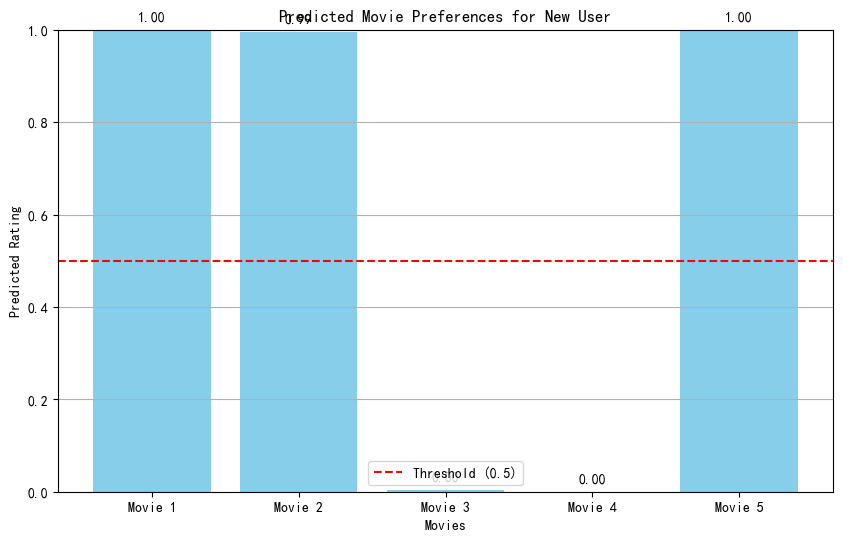

In [208]:
import numpy as np
import matplotlib.pyplot as plt

class RBMMovie:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        # 权重初始化为随机值
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data, epochs=1000):
        for epoch in range(epochs):
            self.contrastive_divergence(data)

    def predict(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible

# 模拟用户对电影的评分数据
# 行代表用户，列代表电影，1 表示喜欢，0 表示不喜欢

user_movie_ratings = np.array(like_hood_list)

# 创建 RBM 模型
rbm = RBMMovie(visible_units=5, hidden_units=3)
rbm.train(user_movie_ratings, epochs=5000)

# 预测某个用户的电影喜好
new_user = np.array([[1, 0, 0, 0, 0]])  # 新用户的观影历史
predicted_ratings = rbm.predict(new_user)

# 可视化预测结果
predicted_ratings = predicted_ratings.flatten()  # 将预测结果展平
movies = [f'Movie {i + 1}' for i in range(len(predicted_ratings))]  # 电影标签

plt.figure(figsize=(10, 6))
plt.bar(movies, predicted_ratings, color='skyblue')
plt.xlabel('Movies')
plt.ylabel('Predicted Rating')
plt.title('Predicted Movie Preferences for New User')
plt.ylim(0, 1)  # 设置y轴范围
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')  # 添加阈值线
plt.legend()
plt.grid(axis='y')

# 显示数值标注
for i, v in enumerate(predicted_ratings):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')

plt.show()


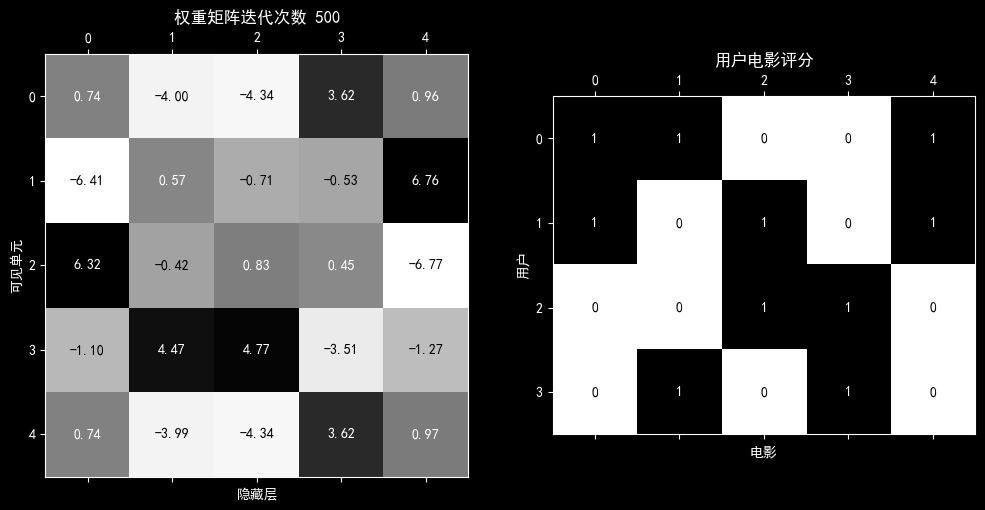

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class RBMMovie:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.weights = np.random.normal(scale=0.01, size=(self.visible_units, self.hidden_units))
        self.visible_bias = np.zeros(self.visible_units)
        self.hidden_bias = np.zeros(self.hidden_units)
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.weights) + self.hidden_bias
        prob_hidden = self.sigmoid(activation)
        return prob_hidden, np.random.binomial(1, prob_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.weights.T) + self.visible_bias
        prob_visible = self.sigmoid(activation)
        return prob_visible, np.random.binomial(1, prob_visible)

    def contrastive_divergence(self, data):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(data)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        neg_visible_probs, _ = self.sample_visible(pos_hidden_states)
        neg_hidden_probs, _ = self.sample_hidden(neg_visible_probs)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        self.weights += self.learning_rate * (pos_associations - neg_associations)
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        loss = np.mean((data - neg_visible_probs) ** 2)
        self.errors.append(loss)

    def train(self, data, epochs=1000):
        for epoch in range(epochs):
            self.contrastive_divergence(data)

    def predict(self, data):
        _, hidden_states = self.sample_hidden(data)
        reconstructed_visible, _ = self.sample_visible(hidden_states)
        return reconstructed_visible

# Simulated user movie ratings data
user_movie_ratings = np.array(like_hood_list)

# Create RBM model and train it
rbm = RBMMovie(visible_units=5, hidden_units=5)
rbm.train(user_movie_ratings, epochs=500)

# Set up plotting parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Weight matrix visualization
cax = ax1.matshow(rbm.weights, cmap='Greys', vmin=-5, vmax=5)
ax1.set_title('权重矩阵', color='white')
ax1.set_xlabel('隐藏层', color='white')
ax1.set_ylabel('可见单元', color='white')

fig.patch.set_facecolor('black')
ax1.patch.set_facecolor('black')
ax1.spines['left'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

# Text annotations for weights
texts = np.empty(rbm.weights.shape, dtype=object)  # Store text annotation objects

# Original input visualization
cax_input = ax2.matshow(user_movie_ratings, cmap='Greys', vmin=0, vmax=1)
ax2.set_title('用户电影评分', color='white')
ax2.set_xlabel('电影', color='white')
ax2.set_ylabel('用户', color='white')

ax2.patch.set_facecolor('black')
ax2.spines['left'].set_color('white')
ax2.spines['bottom'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

# Text annotations for input matrix
texts_input = np.empty(user_movie_ratings.shape, dtype=object)

def update(frame):
    """Update function: Update the weight matrix and input matrix for each training iteration"""
    rbm.train(user_movie_ratings, epochs=1)  # Train once for each frame
    cax.set_array(rbm.weights)  # Update weight matrix
    cax_input.set_array(user_movie_ratings)  # Update input matrix

    # Update weight text annotations
    for (i, j), val in np.ndenumerate(rbm.weights):
        if texts[i, j] is None:
            texts[i, j] = ax1.text(j, i, f'{val:.2f}', ha='center', va='center',
                                   color='white' if val > 0 else 'black')
        else:
            texts[i, j].set_text(f'{val:.2f}')  # Update text content
            
        texts[i, j].set_color('white' if val > 0 else 'black')

    # Update input text annotations
    for (i, j), val in np.ndenumerate(user_movie_ratings):
        if texts_input[i, j] is None:
            texts_input[i, j] = ax2.text(j, i, f'{val}', ha='center', va='center',
                                           color='white' if val > 0 else 'black')
        else:
            texts_input[i, j].set_text(f'{val}')  # Update input text content
            
        texts_input[i, j].set_color('white' if val > 0 else 'black')

    ax1.set_title(f'权重矩阵迭代次数 {frame + 1}')  # Update weight matrix title
    return cax, cax_input

# Create animation
ani = FuncAnimation(fig, update, frames=500, interval=30, repeat=False)

# Save animation
ani.save(r'E:\ipynb\media\videos\tf\rbm_weight_and_input_animation.mp4', writer='ffmpeg')

plt.show()


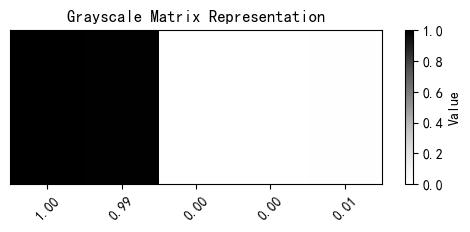

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Given array of values
values = np.array([9.99963749e-01, 9.93367981e-01, 5.01923106e-05, 1.82239281e-05, 5.25196586e-03])

# Reshape the array to a 2D format (1 row, 5 columns)
gray_matrix = values.reshape(1, -1)

# Set up the plot
plt.figure(figsize=(6, 2), dpi=100)
plt.imshow(gray_matrix, cmap='Greys', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Value')

# Set axis labels and title
plt.xticks(ticks=np.arange(len(values)), labels=[f'{val:.2f}' for val in values], rotation=45)
plt.yticks([])
plt.title('Grayscale Matrix Representation')

# Show the plot
plt.show()


In [240]:
%%manim -qh -v WARNING FinalAnswer
class FinalAnswer(Scene):
    def construct(self):
        picture_logo = Group(
            ImageMobject(r"E:\ipynb\media\nobel_prize\cs2.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\buff.jpg").scale(32/447),
            ImageMobject(r"E:\ipynb\media\nobel_prize\dota2.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\jdqs.jpg"),
            ImageMobject(r"E:\ipynb\media\nobel_prize\pvz.jpg"),
        ).scale(2).arrange(buff=0.51)
        
        
        list_ori = [1,0,0,0,0]
        list_fin = [0.999, 0.993, 0.00005, 2e-5, 5e-3]
        ori = SquTex(list_ori).shift(UP).scale(0.5)
        ori.change_square(0,stroke_color = RED)
        ori.change_text(0,color = RED)
        fin = SquTex(list_fin).shift(DOWN).scale(0.5)
        fin.change_square(0,stroke_color = RED)
        fin.change_text(0,color = RED)
        fin.change_square(1,stroke_color = ORANGE)
        fin.change_text(1,color = ORANGE)
        self.play(Create(ori))
        self.wait(2)
        self.play(FadeIn(fin,shift=DOWN*2))
        self.wait(2)
        self.play(FadeIn(picture_logo))
        self.wait()
        
        buff = Group(picture_logo[1],fin[1])
        sur_buf = SurroundingRectangle(buff,buff=0)
        self.play(Create(sur_buf))
        self.wait(2)
        

In [264]:
%%manim -qh -v WARNING RBM
class RBM(Scene):
    def construct(self):
        b = MarkupText('<span foreground="red">R</span><span foreground="orange">B</span><span foreground="yellow">M</span>').shift(UP)
        b_ = MarkupText('<gradient from="red" to="orange">Restricted</gradient> <gradient from="orange" to="yellow">Boltzmann</gradient> <gradient from="yellow" to="white">Machine</gradient>')
        b__ = MarkupText('受限玻尔兹曼机',font='时尚中黑简体').shift(DOWN)
        self.play(Write(b),run_time=2)
        self.wait(2)
        self.play(TransformFromCopy(b,b_,run_time=2))
        self.wait(2)
        self.play(Write(b__,run_time=2))
        self.wait(2)

In [275]:
%%manim -qh -v WARNING HopfieldNetwork

from manim import *

class HopfieldNetwork(Scene):
    def construct(self):
        # 创建神经元节点
        neurons = [Circle(radius=0.1, color=BLUE).shift(2 * RIGHT * i).shift(2 * UP) for i in range(-2, 3) for j in range(-2, 3)]

        # 创建节点之间的连接
        edges = []
        for i in range(len(neurons)):
            for j in range(i + 1, len(neurons)):
                edge = Line(neurons[i].get_center(), neurons[j].get_center(), color=GRAY)
                edges.append(edge)

        # 将节点和连接添加到场景中
        self.play(*[Create(neuron) for neuron in neurons])
        self.play(*[Create(edge) for edge in edges])

        # 动画展示连接的动态变化
        self.play(*[neuron.animate.set_fill(ORANGE, opacity=0.5) for neuron in neurons])
        self.wait(1)
        self.play(*[neuron.animate.set_fill(BLUE, opacity=1) for neuron in neurons])
        self.wait(1)

        # 清除场景
        self.play(*[FadeOut(neuron) for neuron in neurons])
        self.play(*[FadeOut(edge) for edge in edges])
        self.wait(1)

# 运行代码
# manim -pql hopfield.py HopfieldNetwork



In [291]:
%%manim -qh -v WARNING ThreeDTextRotation
class ThreeDTextRotation(ThreeDScene):
    def construct(self):
        # 创建二维文字对象
        text_2d = Text("rainbow鱼", font_size=48)
        for i in range(len(text_2d)):
            text_2d[i].set_color_by_gradient(rainbow_color8[i])

        # 将立体文字对象添加到场景中
        self.add(text_2d)

        # 设置摄像机视角并旋转
        self.set_camera_orientation(phi=75 * DEGREES, theta=-45 * DEGREES)
        self.begin_ambient_camera_rotation(rate=-0.1)

        self.wait(8)  # 等待一段时间